In [1]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 40.8 MB/s eta 0:00:00


In [2]:
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt

import pytorch_lightning as pl

random_seed = 42
torch.manual_seed(random_seed)

BATCH_SIZE = 128
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS = int(os.cpu_count() / 2)

print(AVAIL_GPUS)
print(NUM_WORKERS)

1
1


In [3]:
class MNISTDataModule(pl.LightningDataModule):
  def __init__(self, data_dir="./data",
               batch_size = BATCH_SIZE, num_workers = NUM_WORKERS):
    super().__init__()
    self.data_dir = data_dir
    self.batch_size = batch_size
    self.num_workers = num_workers

    self.transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
        ]
      )

  def prepare_data(self):
    MNIST(self.data_dir, train = True, download = True)
    MNIST(self.data_dir, train = False, download = True)

  def setup(self, stage = None):
    if stage == "fit" or stage is None:
      mnist_full = MNIST(self.data_dir, train = True, transform = self.transform)
      self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

    if stage == "test" or stage is None:
      self.mnist_test = MNIST(self.data_dir, train = False, transform = self.transform)

  def train_dataloader(self):
    return DataLoader(self.mnist_train, batch_size = self.batch_size, num_workers = self.num_workers)

  def val_dataloader(self):
    return DataLoader(self.mnist_val, batch_size = self.batch_size, num_workers = self.num_workers)

  def test_dataloader(self):
    return DataLoader(self.mnist_test, batch_size = self.batch_size, num_workers= self.num_workers)

In [4]:
# Implementing the Discriminator
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    # Simple Convolutional Network
    self.conv1 = nn.Conv2d(1, 10, kernel_size = 5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size = 5)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 1)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))

    #flattening the tensor so that it can be fed into the FC layers
    x = x.view(-1, 320)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training = self.training)
    x = self.fc2(x)
    return torch.sigmoid(x)

In [5]:
#Generate Fake Data: output like real data [1, 28, 28]
class Generator(nn.Module):
  def __init__(self, latent_dim):
    super().__init__()
    self.lin1 = nn.Linear(latent_dim, 7*7*64)
    self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride = 2)
    self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride = 2)
    self.conv = nn.Conv2d(16, 1, kernel_size = 7)

  def forward(self, x):
    # Pass latent space input into linear layer nd reshape
    x = self.lin1(x)
    x = F.relu(x)
    x = x.view(-1, 64, 7, 7)

    # Upsample (transposed conv) 16x16 (64 feature maps)
    x = self.ct1(x)
    x = F.relu(x)

    # Upsample (transposed conv) 32x32
    x = self.ct2(x)
    x = F.relu(x)

    # Convolutional layer
    x = self.conv(x)

    return x

In [14]:
# class GAN(pl.LightningModule):
#   def __init__(self, latent_dim= 100, lr = 0.0002):
#     super().__init__()
#     self.save_hyperparameters()
#     self.automatic_optimization = False

#     self.generator = Generator(latent_dim = self.hparams.latent_dim)
#     self.discriminator = Discriminator()

#     #random noise
#     self.validation_z = torch.randn(6, self.hparams.latent_dim)

#   def forward(self, z):
#     return self.generator(z)

#   def adversarial_loss(self, y_hat, y):
#     return F.binary_cross_entropy(y_hat, y)

#   def training_step(self, batch, batch_idx, optimizer_idx):
#     real_imgs, _ = batch

#     z = torch.randn(real_imgs.shape[0], self.hparams.latent_dim)
#     z = z.type_as(real_imgs)

#     # Train Generator: max log(D(G(z)))
#     if optimizer_idx == 0:
#       fake_imgs = self(z)
#       y_hat = self.discriminator(fake_imgs)
#       y = torch.ones(real_imgs.size(0), 1)
#       y = y.type_as(real_imgs)

#       g_loss = self.adversarial_loss(y_hat, y)
#       log_dict = {"g_loss" : g_loss}
#       return {"loss": g_loss, "progress_bar": log_dict, "log": log_dict}

#     # Train Discriminator: max log(D(x)) + log(1-D(G(z)))
#     if optimizer_idx == 1:
#       #how well can it label as real
#       y_hat_real = self.discriminator(real_imgs)
#       y_real = torch.ones(real_imgs.size(0), 1)
#       y_real = y_hat_real.type_as(real_imgs)

#       real_loss = self.adversarial_loss(y_hat_real, y_real)

#       #how well can it label as fake
#       y_hat_fake = self.discriminator(self(z).detach())
#       y_fake = torch.zeros(real_imgs.size(0), 1)
#       y_fake = y_fake.type_as(real_imgs)

#       fake_loss = self.adversarial_loss(y_hat_fake, y_fake)

#       d_loss = (real_loss + fake_loss) / 2
#       log_dict = {"d_loss" : d_loss}
#       return {"loss": d_loss, "progress_bar": log_dict, "log": log_dict}


#   def configure_optimizers(self):
#     lr = self.hparams.lr
#     b1 = 0.5
#     b2 = 0.999
#     opt_g = torch.optim.Adam(self.generator.parameters(), lr = lr)
#     opt_d = torch.optim.Adam(self.discriminator.parameters(), lr = lr)
#     return [opt_g, opt_d], []

#   def plot_imgs(self):
#     z = self.validation_z.type_as(self.generator.lin1.weight)
#     sample_imgs = self(z).cpu()
#     print("epoch ", self.current_epoch)
#     fig = plt.figure()
#     for i in range(sample_imgs.size(0)):
#       plt.subplot(2, 3, i + 1)
#       plt.tight_layout()
#       plt.imshow(sample_imgs.detach()[i, 0, :, :], cmap = "gray_r", interpolation = "none")
#       plt.title("Generated Data")
#       plt.xticks([])
#       plt.yticks([])
#       plt.axis("off")
#     plt.show()

#   def on_epoch_end(self):
#     self.plot_imgs()

In [26]:
class GAN(pl.LightningModule):
  def __init__(self, latent_dim=100, lr=0.0002):
    super().__init__()
    self.save_hyperparameters()

    # Disable automatic optimization
    self.automatic_optimization = False

    self.generator = Generator(latent_dim=self.hparams.latent_dim)
    self.discriminator = Discriminator()

    # random noise
    self.validation_z = torch.randn(6, self.hparams.latent_dim)

  def forward(self, z):
    return self.generator(z)

  def adversarial_loss(self, y_hat, y):
    return F.binary_cross_entropy(y_hat, y)

  def training_step(self, batch, batch_idx):
    real_imgs, _ = batch

    # Get optimizers
    opt_g, opt_d = self.optimizers()

    # Generate random noise
    z = torch.randn(real_imgs.shape[0], self.hparams.latent_dim)
    z = z.type_as(real_imgs)

    # Train Generator: max log(D(G(z)))
    opt_g.zero_grad()
    fake_imgs = self(z)
    y_hat = self.discriminator(fake_imgs)
    y = torch.ones(real_imgs.size(0), 1)
    y = y.type_as(real_imgs)

    g_loss = self.adversarial_loss(y_hat, y)
    self.manual_backward(g_loss)
    opt_g.step()

    # Train Discriminator: max log(D(x)) + log(1-D(G(z)))
    opt_d.zero_grad()

    # How well can it label as real
    y_hat_real = self.discriminator(real_imgs)
    y_real = torch.ones(real_imgs.size(0), 1)
    y_real = y_real.type_as(real_imgs)
    real_loss = self.adversarial_loss(y_hat_real, y_real)

    # How well can it label as fake
    y_hat_fake = self.discriminator(self(z).detach())
    y_fake = torch.zeros(real_imgs.size(0), 1)
    y_fake = y_fake.type_as(real_imgs)
    fake_loss = self.adversarial_loss(y_hat_fake, y_fake)

    d_loss = (real_loss + fake_loss) / 2
    self.manual_backward(d_loss)
    opt_d.step()

    # Log losses
    self.log("g_loss", g_loss, prog_bar=True)
    self.log("d_loss", d_loss, prog_bar=True)

  def configure_optimizers(self):
    lr = self.hparams.lr
    b1 = 0.5
    b2 = 0.999
    opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(b1, b2))
    opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(b1, b2))
    return [opt_g, opt_d]

  def plot_imgs(self):
    z = self.validation_z.type_as(self.generator.lin1.weight)
    sample_imgs = self(z).cpu()
    print("epoch ", self.current_epoch)
    fig = plt.figure()
    for i in range(sample_imgs.size(0)):
      plt.subplot(2, 3, i + 1)
      plt.tight_layout()
      plt.imshow(sample_imgs.detach()[i, 0, :, :], cmap="gray_r", interpolation="none")
      plt.title("Generated Data")
      plt.xticks([])
      plt.yticks([])
      plt.axis("off")
    plt.show()

  def on_train_epoch_end(self):
    self.plot_imgs()

In [27]:
dm = MNISTDataModule()
model = GAN()

epoch  0


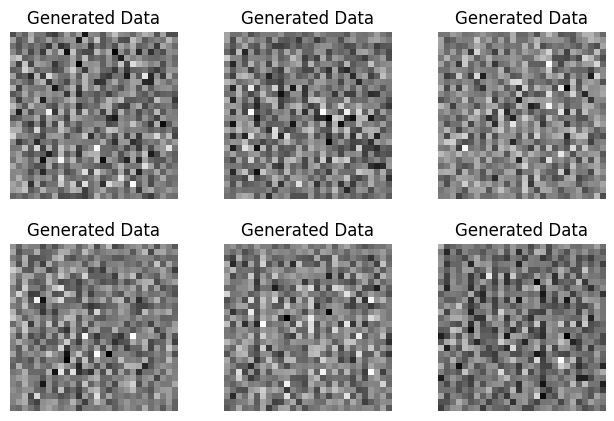

In [28]:
model.plot_imgs()

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ generator     │ Generator     │  358 K │ train │     0 │
│ 1 │ discriminator │ Discriminator │ 21.4 K │ train │     0 │
└───┴───────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 379 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 379 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 11                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

epoch  0

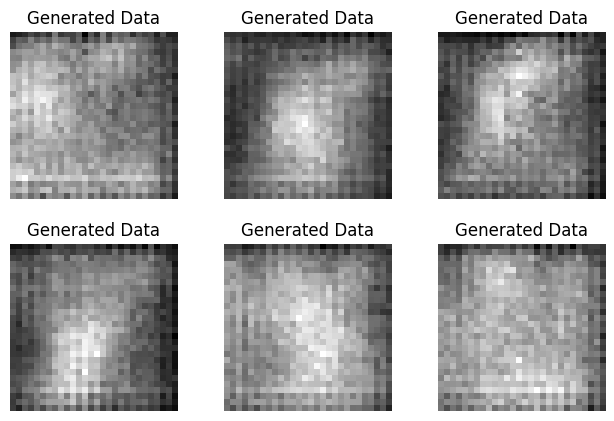

epoch  1

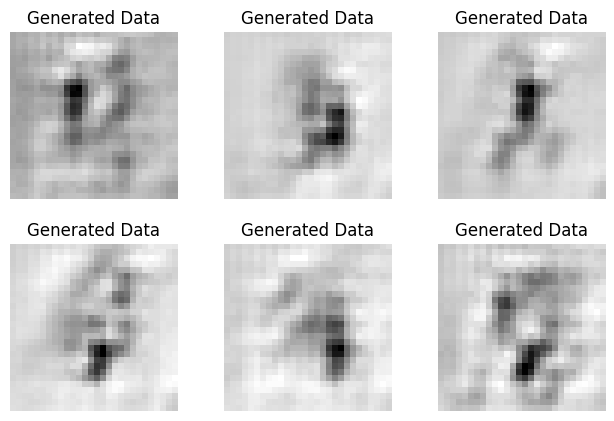

epoch  2

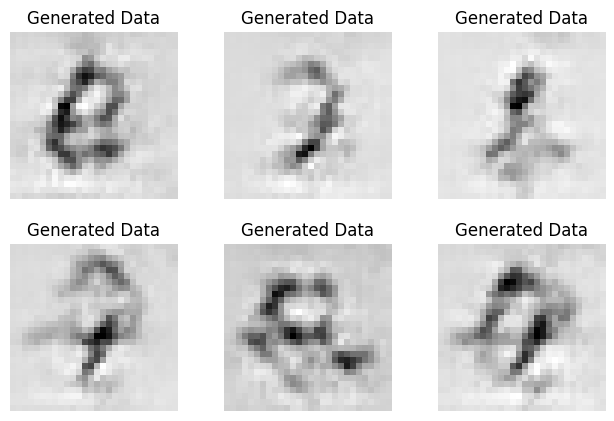

epoch  3

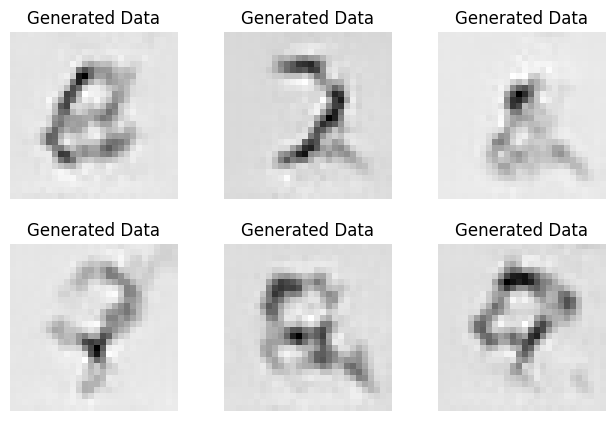

epoch  4

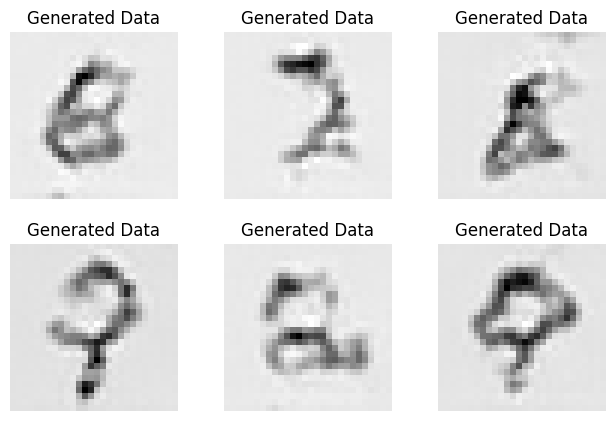

epoch  5

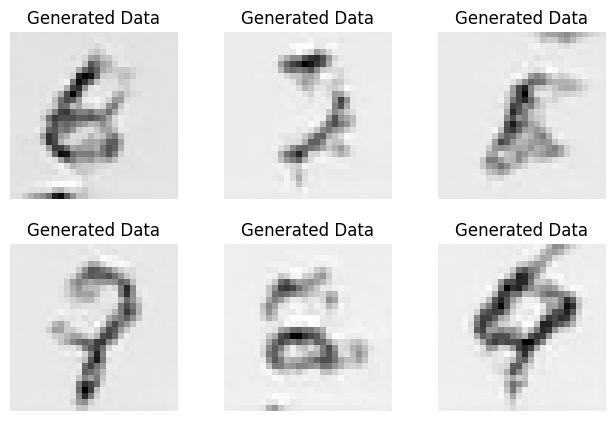

epoch  6

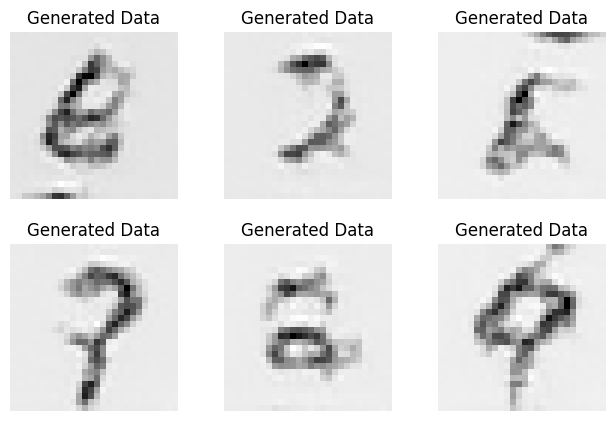

epoch  7

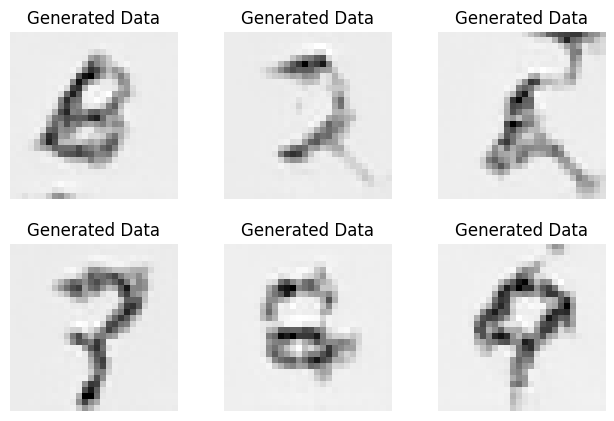

epoch  8

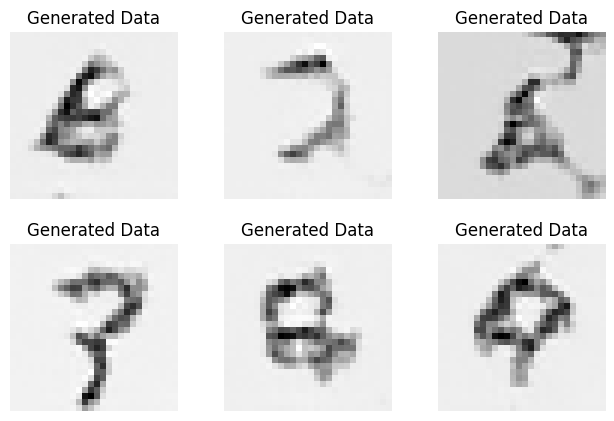

epoch  9

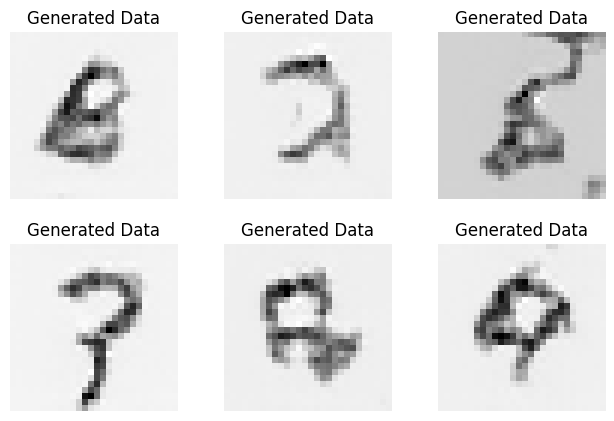

epoch  10

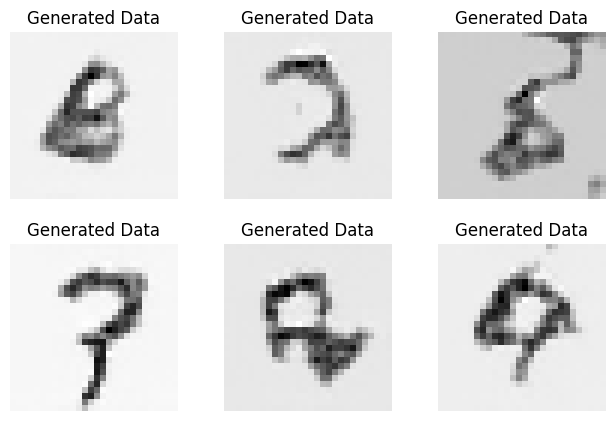

epoch  11

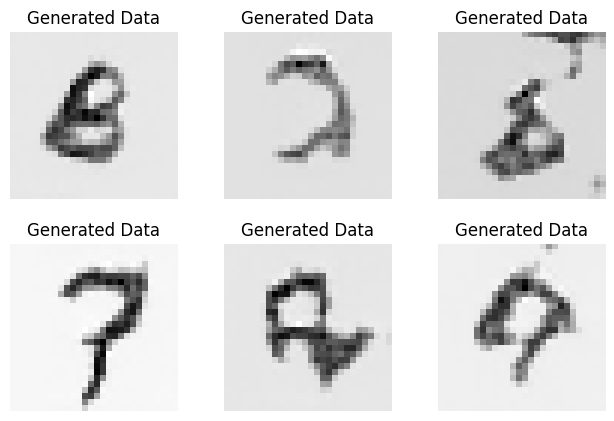

epoch  12

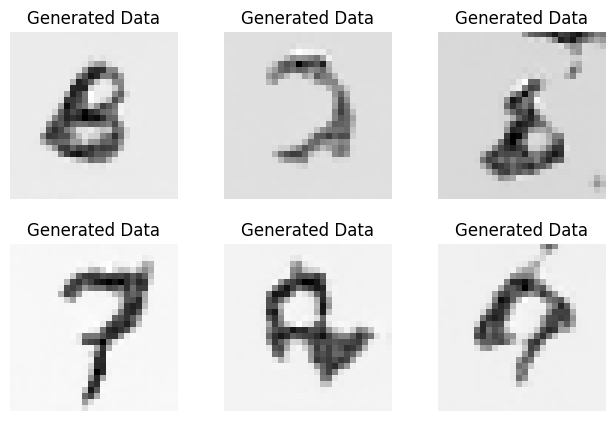

epoch  13

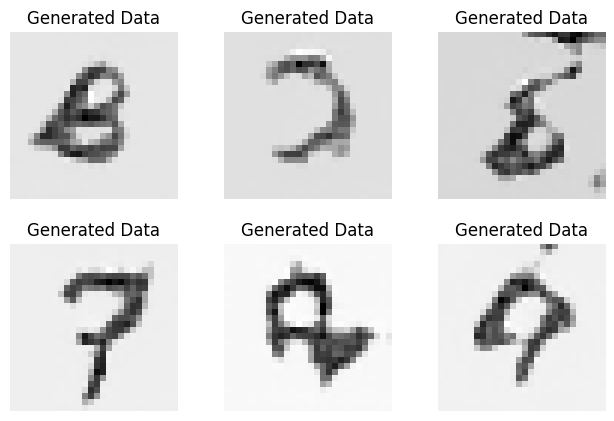

epoch  14

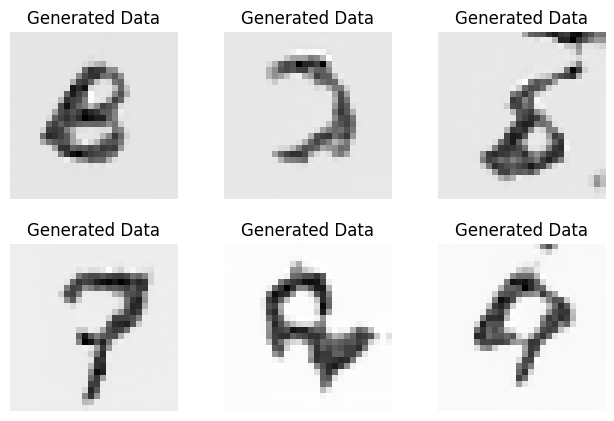

epoch  15

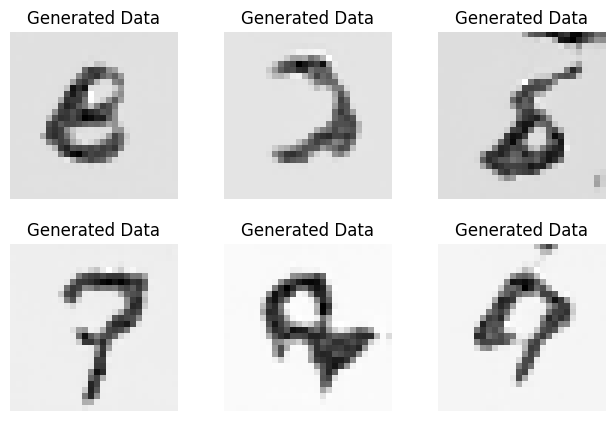

epoch  16

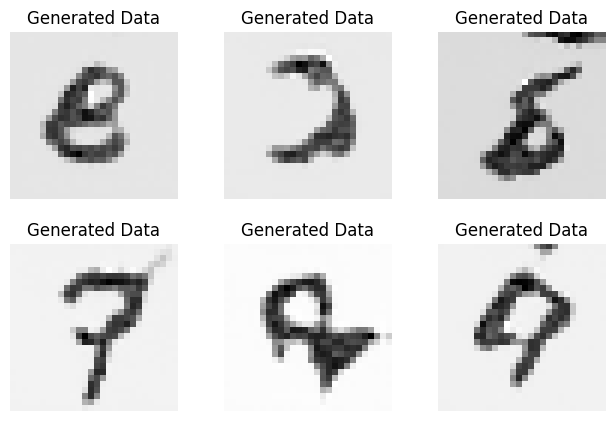

epoch  17

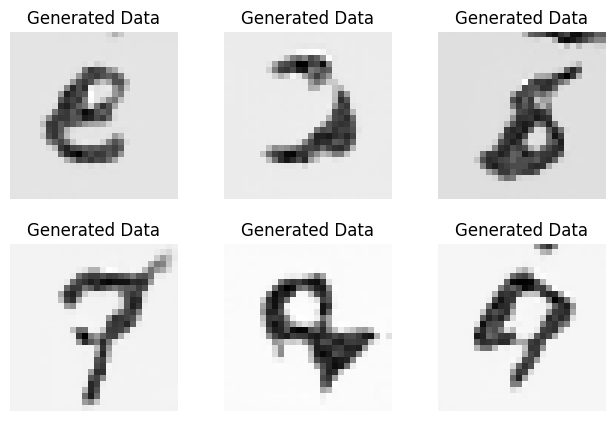

epoch  18

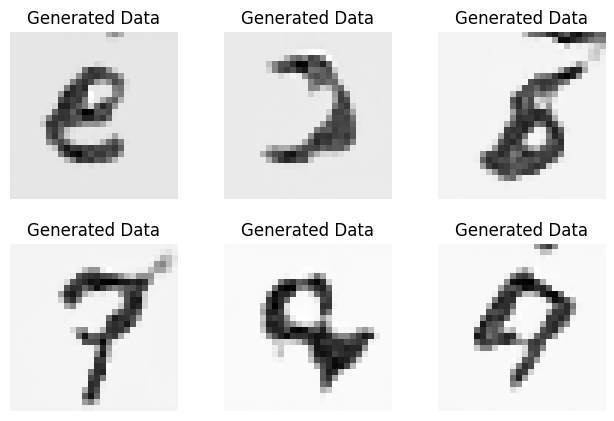

epoch  19

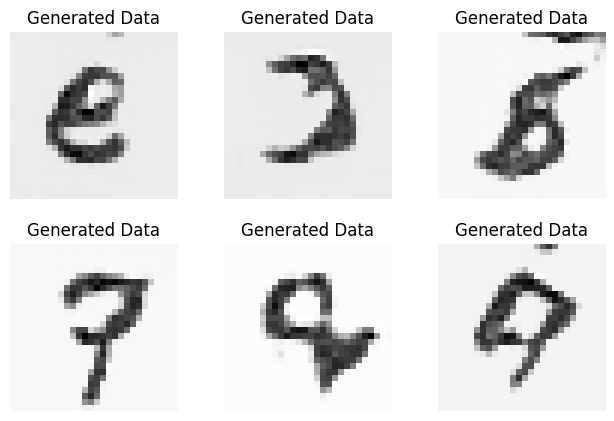

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [29]:
trainer = pl.Trainer(max_epochs= 20, accelerator='gpu', devices=AVAIL_GPUS)
trainer.fit(model, dm)

In [30]:
print("Final metrics:", trainer.logged_metrics)
print("Callback metrics:", trainer.callback_metrics)

Final metrics: {'g_loss': tensor(1.4284), 'd_loss': tensor(0.3515)}
Callback metrics: {'g_loss': tensor(1.4284), 'd_loss': tensor(0.3515)}
